# Aufgabe 6: Clustering Customers using K-means in HANA

SAP HANA ist eine in-memory Datenbank, welche zur schnellen Verarbeitung von großen Datenmengen eingesetzt werden kann. HANA kann wie eine klassische relationale Datenbank verwendet werden und bietet zusätzlich Funktionen zur Analyse der gespeicherten Daten. Durch die Haltung aller Daten im Arbeitsspeicher und der spaltenorientierten Architektur können auch große Datenmengen in echtzeit analysiert werden.

## Aufgabenstellung
Lesen Sie das Kapitel 5.3 (S. 32) des SDIL Tutorials und bearbeiten Sie die Aufgaben wie
beschrieben. Geben Sie Ihren Workflow als Lösung ab. Berichten Sie von Ihren Erfahrungen
mit HANA.

## Daten importieren
Zum Import der Daten muss die entsprechende Tabelle erst über einen SQL-Befehl erstellt werden und anschließend die Daten importiert werden. Der Import kann durch einen weiteren SQL-Befehl geschehen oder direkt über die GUI der Entwicklungsumgebung gemacht werden.

## K-Means Analyse mit dem Application Function Modeler (AFM)
Mit dem Application Function Modeler (AFM) ist es mögliche einen Datensatz zu analysieren, ohne dafür Code schreiben zu müssen. Stattdessen kann die Analyse mithilfe eines graphbasierten Systems modelliert werden. Dabei werden die Quell- und Zieltabellen als Graphknoten dargestellt und durch weitere Knoten verbunden, welche die einzelnen Bearbeitungsschritte darstellen. Der fertige Verarbeitungsgraph für die K-Means Analyse sieht wie folgt aus:
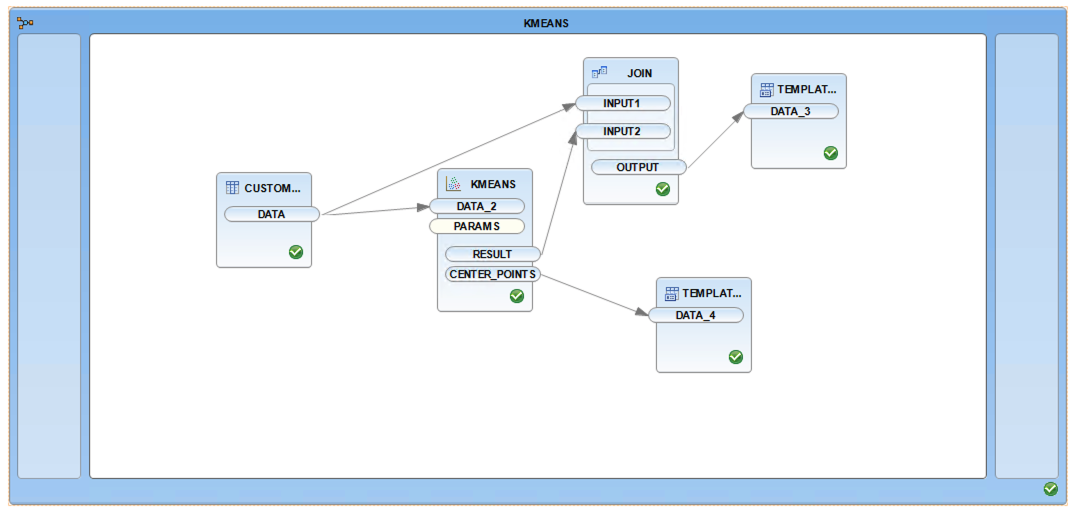

## K-Means Analyse mit SQL-Script
Alternativ zum AFM kann auch SQL-Script verwendet werden, um eine Analyse der Daten durchzuführen. Hierbei müssen Funktionen wie die K-Means Funktion manuell aufgerufen werden. Für die benötigten Parameter müssen dabei spezielle Tabellen angelegt werden, welche die Werte der Parameter enthalten. Der Aufruf der K-Means Funktion benötigt die Erzeugung eines AFL Wrappers, welcher wiederum durch eine spezielle Tabelle die Signatur der K-Means Funktion erhält. 
Der Quellcode zum Anwenden des K-Means Algorithmus und anschließender Evaluation sieht wie folgt aus:
```sql
/* Apply K-Means clustering to customer dataset */

/* Define table types that will be used in the script */
CREATE TYPE PAL_T_KM_DATA AS TABLE (ID INTEGER, INCOME DOUBLE, LOYALTY DOUBLE);
CREATE TYPE PAL_T_KM_PARAMS AS TABLE (NAME VARCHAR(60), INTARGS INTEGER, DOUBLEARGS DOUBLE, STRINGARGS VARCHAR (100));
CREATE TYPE PAL_T_KM_RESULTS AS TABLE (ID INTEGER, CENTER_ID INTEGER, DISTANCE DOUBLE);
CREATE TYPE PAL_T_KM_CENTERS AS TABLE (CENTER_ID INTEGER, INCOME DOUBLE, LOYALTY DOUBLE);

/* Table to generate K-Means procedure */
CREATE COLUMN TABLE PAL_KM_SIGNATURE (ID INTEGER, TYPENAME VARCHAR(1000), DIRECTION VARCHAR(100));
INSERT INTO PAL_KM_SIGNATURE VALUES (1, 'UTNSU.PAL_T_KM_DATA', 'in');
INSERT INTO PAL_KM_SIGNATURE VALUES (2, 'UTNSU.PAL_T_KM_PARAMS', 'in');
INSERT INTO PAL_KM_SIGNATURE VALUES (3, 'UTNSU.PAL_T_KM_RESULTS', 'out');
INSERT INTO PAL_KM_SIGNATURE VALUES (4, 'UTNSU.PAL_T_KM_CENTERS', 'out');

/* Create K-Means Procedure with ALF wrapper generator */
CALL SYSTEM.AFL_WRAPPER_GENERATOR ('PAL_KM', 'AFLPAL', 'KMEANS', PAL_KM_SIGNATURE);

/* Create view with only income and loyalty */
CREATE VIEW V_KM_DATA AS 
	SELECT ID, INCOME, LOYALTY
		FROM CUSTOMERS;
		
/* Create and fill parameter table */
CREATE COLUMN TABLE KM_PARAMS LIKE PAL_T_KM_PARAMS;
INSERT INTO KM_PARAMS VALUES ('THREAD_NUMBER', 2, null, null);
INSERT INTO KM_PARAMS VALUES ('GROUP_NUMBER', 3, null, null);
INSERT INTO KM_PARAMS VALUES ('INIT_TYPE', 1, null, null);
INSERT INTO KM_PARAMS VALUES ('DISTANCE_LEVEL', 2, null, null);
INSERT INTO KM_PARAMS VALUES ('MAX_ITERATION', 100, null, null);
INSERT INTO KM_PARAMS VALUES ('NORMALIZATION', 0, null, null);
INSERT INTO KM_PARAMS VALUES ('EXIT_THRESHOLD', null, 0.0001, null);

/* Create result tables */
CREATE COLUMN TABLE KM_RESULTS_FROM_SCRIPT LIKE PAL_T_KM_RESULTS;
CREATE COLUMN TABLE KM_CENTER_POINTS_SCRIPT LIKE PAL_T_KM_CENTERS;

/* create some views to analyze later the results */
CREATE VIEW V_KM_RESULTS_FROM_SCRIPT AS
	SELECT a.ID, b.CUSTOMER,  b.INCOME, b.LOYALTY, a.CENTER_ID + 1 AS CLUSTER_NUMBER
		FROM KM_RESULTS_FROM_SCRIPT a, CUSTOMERS b 
		WHERE a.ID = b.ID;
		
/* call K-Means procedure */
CALL _SYS_AFL.PAL_KM (V_KM_DATA, KM_PARAMS, KM_RESULTS_FROM_SCRIPT, KM_CENTER_POINTS_SCRIPT) WITH OVERVIEW;


------------------------------------------------
-- K-Mean Validation
------------------------------------------------

/* Define table types */
CREATE TYPE PAL_T_KM_V_TYPE_ASSIGN AS TABLE (ID INTEGER, TYPE_ASSIGN INTEGER);
CREATE TYPE PAL_T_KM_V_RESULTS AS TABLE (NAME VARCHAR(50), S DOUBLE);

CREATE COLUMN TABLE PAL_KM_V_SIGNATURE (ID INTEGER, TYPENAME VARCHAR(100), DIRECTION VARCHAR(100));
INSERT INTO PAL_KM_V_SIGNATURE VALUES (1, 'UTNSU.PAL_T_KM_DATA', 'in');
INSERT INTO PAL_KM_V_SIGNATURE VALUES (2, 'UTNSU.PAL_T_KM_V_TYPE_ASSIGN', 'in');
INSERT INTO PAL_KM_V_SIGNATURE VALUES (3, 'UTNSU.PAL_T_KM_PARAMS', 'in');
INSERT INTO PAL_KM_V_SIGNATURE VALUES (4, 'UTNSU.PAL_T_KM_V_RESULTS', 'out');
	
/* Create K-Means validation Procedure with ALF wrapper generator */	
CALL SYSTEM.AFL_WRAPPER_GENERATOR ('PAL_KM_V', 'AFLPAL', 'VALIDATEKMEANS', PAL_KM_V_SIGNATURE);

CREATE VIEW V_KM_TYPE_ASSIGN AS 
	SELECT ID, CENTER_ID AS TYPE_ASSIGN 
		FROM KM_RESULTS_FROM_SCRIPT;

/* Fill the Parameters Table */
CREATE COLUMN TABLE KM_V_PARAMS LIKE PAL_T_KM_PARAMS;
CREATE COLUMN TABLE KM_V_RESULTS LIKE PAL_T_KM_V_RESULTS;
INSERT INTO KM_V_PARAMS VALUES ('VARIABLE_NUM', 2, null, null);
INSERT INTO KM_V_PARAMS VALUES ('THREAD_NUMBER', 1, null, null);

/* Call the Validate KMeans procedure */
CALL _SYS_AFL.PAL_KM_V (V_KM_DATA, V_KM_TYPE_ASSIGN, KM_V_PARAMS, KM_V_RESULTS) WITH OVERVIEW;
```

## Visualisierung der Ergebnisse
Beide Methoden, der AFM und SQL-Script, schreiben das Ergebnis der K-Means Analyse in eine Ausgabetabelle. Der Inhalt dieser Tabelle kann im Hana-Studio einfach visualisiert werden. Hierfür muss nur angegeben werden, welche Variable auf welcher Achse dargestellt werden soll und welche Art von Plot verwendet werden soll. Für dieses Beispiel wurde ein Scatterplot erstellt und die Punkte, die zu einem Cluster gehören, entsprechend gleich eingefärbt.
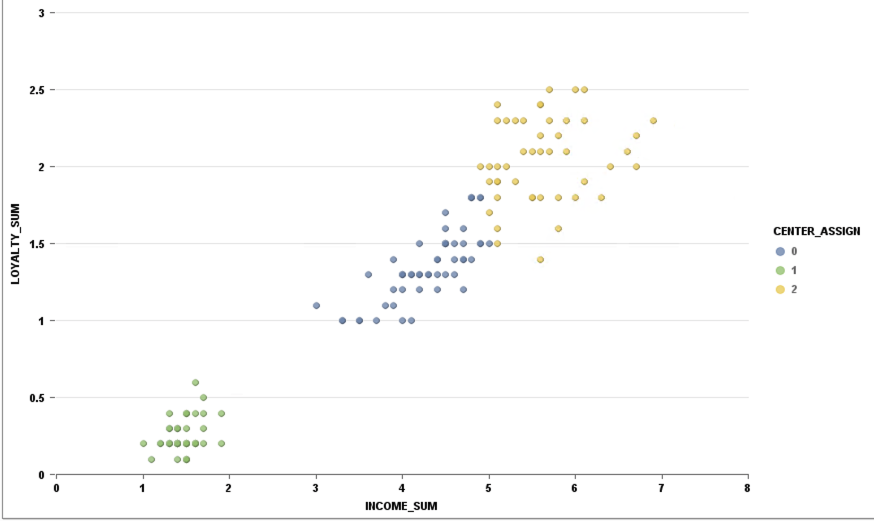

## Fazit und Erfahrungen mit SAP HANA
Der Application Function Modeler erlaubt es auch ohne tiefe Programmierkenntnisse schnell eine Analyse der Daten durchzuführen. Das Zusammenklicken der einzelnen Komponenten hat schnell und einfach funktioniert. Allerdings war dies nur ein sehr einfaches Beispiel. In einem größeren Projekt kann das visuelle Modellieren schnell unübersichtlich werden.

Hierfür sollte dann SQL-Script besser sein, da mehr Kontrolle durch die Verwendung einer Programmiersprache gegeben ist. Allerdings sind die Erfahrungen mit SQL-Script in diesem Tutorial eher negativ gewesen. Es scheint sehr umständlich und viele Zeilen Code sind nötig, um eine einfache K-Means Analyse durchzuführen. Dies liegt vor allem daran, dass für die Übergabe von Parametern extra Tabellen angelegt werden müssen und das Erstellen AFL Wrapper sehr aufwendig ist. Nachdem man sich an SQL-Script gewöhnt hat und ggf. Hilfsfunktionen erstellt hat, kann SAP HANA aber bestimmt ein mächtiges Werkzeug sein, um große Datenbestände zu analysieren.

Die Geschwindigkeit auf großen Daten konnte in diesem Tutorial nicht gezeigt werden, da nur ein sehr kleiner Datensatz verwendet wurde.